## Importing Packages

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from tqdm import tqdm

## Configuration

In [ ]:
# Number of features in input
INPUT_DIMS = 1
# Sequence length of input
WINDOW_SIZE = 14
# Number of hidden layer neurons in LSTM
HIDDEN_SIZE = 128
# Number of LSTMs
NUM_LSTMS = 4

BATCH_SIZE = 32
EPOCHS = 100

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Getting Data from API

In [ ]:
# Get your API key from https://www.alphavantage.co/support/#api-key
api_key = ''
ticker = 'IBM'
df = pd.read_csv(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&datatype=csv&apikey={api_key}')

## Train Data (10 Years)

In [ ]:
train_df = df[(df['timestamp'] >= '2012-01-01') & (df['timestamp'] < '2022-01-01')]
train_df

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
303,2021-12-31,134.00,134.99,133.61,133.66,125.716588,3315313,0.0,1.0
304,2021-12-30,133.75,134.37,133.33,133.91,125.951730,3158111,0.0,1.0
305,2021-12-29,132.40,134.21,132.30,133.35,125.425011,4239935,0.0,1.0
306,2021-12-28,131.60,133.22,131.59,132.63,124.747801,3447079,0.0,1.0
307,2021-12-27,130.63,131.65,129.95,131.62,123.797825,4294499,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2815,2012-01-09,182.20,182.27,180.27,181.59,114.027977,5201200,0.0,1.0
2816,2012-01-06,184.39,184.48,182.31,182.54,114.624521,4897100,0.0,1.0
2817,2012-01-05,184.81,185.03,183.10,184.66,115.955758,4463100,0.0,1.0
2818,2012-01-04,185.57,186.33,184.94,185.54,116.508347,4346700,0.0,1.0


## Test Data (1 Year)

In [ ]:
test_df = df[(df['timestamp'] >= '2022-01-01') & (df['timestamp'] < '2023-01-01')]
test_df

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
52,2022-12-30,140.54,140.9000,139.4500,140.89,139.173098,2858110,0.0,1.0
53,2022-12-29,140.58,142.2600,140.4500,141.06,139.341027,2337207,0.0,1.0
54,2022-12-28,142.40,142.8100,139.9500,140.02,138.313700,2539577,0.0,1.0
55,2022-12-27,141.73,142.7200,141.2300,142.42,140.684453,2742525,0.0,1.0
56,2022-12-23,140.59,141.8565,139.6000,141.65,139.923837,2092715,0.0,1.0
...,...,...,...,...,...,...,...,...,...
298,2022-01-07,134.90,135.6618,133.5111,134.83,126.817055,5238099,0.0,1.0
299,2022-01-06,138.20,138.4099,132.5100,135.34,127.296746,9908081,0.0,1.0
300,2022-01-05,138.31,142.2000,137.8800,138.22,130.005587,8956910,0.0,1.0
301,2022-01-04,136.10,139.9500,135.9000,138.02,129.817473,7300011,0.0,1.0


## Getting the Prices, and Timestamps as lists 

In [ ]:
train_series = train_df['close'].to_list()[::-1]
train_time = train_df['timestamp'].to_list()[::-1]
train_time = [date.fromisoformat(time) for time in train_time]

In [ ]:
test_series = test_df['close'].to_list()[::-1]
test_time = test_df['timestamp'].to_list()[::-1]
test_time = [date.fromisoformat(time) for time in test_time]

## Plotting Prices for Each Day

### Train Plot

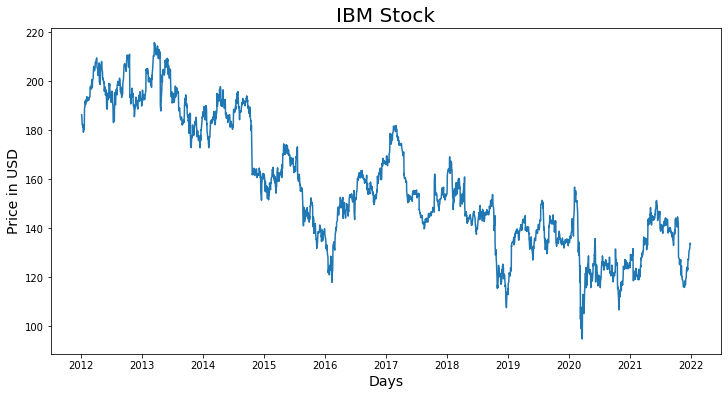

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_time, train_series)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.title(f'{ticker} Stock', fontsize=20)
plt.show()

### Test Plot

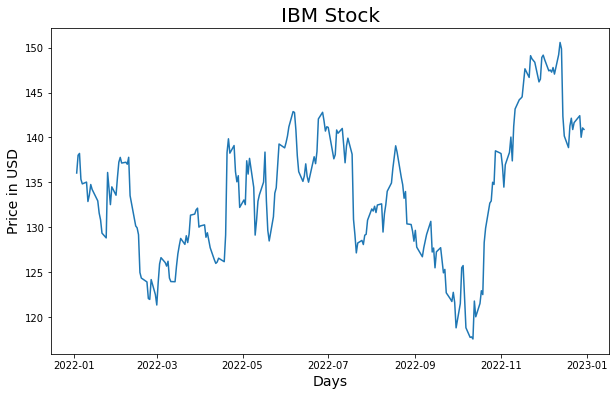

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_time, test_series)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.title(f'{ticker} Stock', fontsize=20)
plt.show()

## Custom Dataset Class

In [ ]:
class SeriesDataset(Dataset):
  def __init__(self, series, window_size):
    self.series = series
    self.window_size = window_size

  def __len__(self):
    return len(self.series) - self.window_size

  def __getitem__(self, idx):
    window = self.series[idx: idx + self.window_size]
    label = self.series[idx + self.window_size]

    return torch.tensor(window).unsqueeze(-1), torch.tensor([label])

## Creating Dataloaders

In [ ]:
train_dataset = SeriesDataset(train_series, WINDOW_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_dataset = SeriesDataset(test_series, WINDOW_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Defining the Model

In [ ]:
class LSTM_Model(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM_Model, self).__init__()

    self.relu = nn.ReLU()

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, batch_first=True)
    
    self.fc1 = nn.Linear(hidden_size, 128)
    self.fc2 = nn.Linear(128, 1)


  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.fc1(x[:, -1])
    x = self.relu(x)
    return self.fc2(x)

## Initializing the Model

In [ ]:
model = LSTM_Model(INPUT_DIMS, HIDDEN_SIZE, NUM_LSTMS)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters())
loss_function = nn.L1Loss()

## Training the Model

In [ ]:
for epoch in range(EPOCHS):
  loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', colour='green')
  for window, y in loop:
    window = window.to(DEVICE)
    y = y.to(DEVICE)
    
    output = model(window)
    loss = loss_function(y, output)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_postfix({'L1 Loss': loss.item()})

Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 124.46it/s, L1 Loss=1.67]


## Generating Predictions

In [ ]:
predictions = []
model.eval()

loop = tqdm(test_dataloader, colour='green')
for window, y in loop:
  window = window.to(DEVICE)
  y = y.to(DEVICE)
  
  output = model(window)

  for val in output.flatten():
    predictions.append(val.item())

100%|██████████| 8/8 [00:00<00:00, 353.37it/s]


## Plotting the Predictions against the Test Data

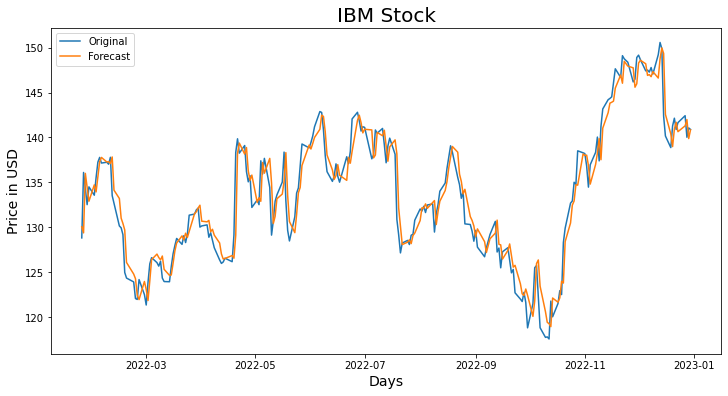

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_time[WINDOW_SIZE:], test_series[WINDOW_SIZE:], label='Original')
plt.plot(test_time[WINDOW_SIZE:], predictions, label='Forecast')
plt.legend()
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.title(f'{ticker} Stock', fontsize=20)
plt.show()